In [6]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten, Conv2D, Activation, MaxPooling2D
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
# Load images and labels
path = '/content/drive/MyDrive/Deep_learning_projects/SheepFullImages'
sheep_breed_list = os.listdir(path)
print(sheep_breed_list)

['Suffolk', 'Poll Dorset', 'White Suffolk', 'Marino']


In [10]:
def load_and_preprocess_images(path, target_size=(224, 224)):
    img_data_list = []
    labels = []

    for idx, sheep_breed in enumerate(sheep_breed_list):
        sheep_breed_files = os.listdir(os.path.join(path, sheep_breed))
        print(sheep_breed_files)
        for img_file in sheep_breed_files:
            sheep_image_path = os.path.join(path, sheep_breed, img_file)
            try:
                img = image.load_img(sheep_image_path, target_size=target_size)
                img_array = image.img_to_array(img)
                img_array = preprocess_input(img_array)
                img_data_list.append(img_array)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {img_file}: {e}")

    # Convert lists to numpy arrays and preprocess
    img_data = np.array(img_data_list)
    labels = np.array(labels)

    # Shuffle data
    img_data, labels = shuffle(img_data, labels, random_state=777)

    return img_data, labels, sheep_breed_list

img_data_path = '/content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheep_img_data.npy'
labels_path = '/content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheep_labels.npy'

if os.path.exists(img_data_path) and os.path.exists(labels_path):
    img_data = np.load(img_data_path)
    labels = np.load(labels_path)
else:
    img_data, labels, sheep_breed_list = load_and_preprocess_images(path)
    # Save the processed data
    np.save(img_data_path, img_data)
    np.save(labels_path, labels)

print('Data Shape:', img_data.shape)
print('Labels Shape:', labels.shape)

Data Shape: (1619, 224, 224, 3)
Labels Shape: (1619,)


In [11]:
# One-hot encode labels
labels_categorical = to_categorical(labels, num_classes=len(sheep_breed_list))

print(labels_categorical.shape)

(1619, 4)


In [12]:
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = base_model.output

    # Flatten to prepare for the fully connected layers
    x = Flatten()(x)

    # Fully connected + ReLU
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Adding output layer
    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model.layers[:15]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model.layers[15:-4]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.0001
            lr_mult[layer.name + '/bias:0'] = 0.0001

    # Set learning rate to 10 for the last two dense layers
    for layer in model.layers[-4:]:
        lr_mult[layer.name + '/kernel:0'] = 10
        lr_mult[layer.name + '/bias:0'] = 10

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4,momentum=0.9)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model = build_model()

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=1)
    history = model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.2, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model=load_model(save_path)
    # Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')
    print("\n")

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 1.5677 - accuracy: 0.5502
Epoch 1: val_loss improved from inf to 0.93505, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 29s 218ms/step - loss: 1.5677 - accuracy: 0.5502 - val_loss: 0.9350 - val_accuracy: 0.5792
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.7683
Epoch 2: val_loss improved from 0.93505 to 0.49222, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 84ms/step - loss: 0.5933 - accuracy: 0.7683 - val_loss: 0.4922 - val_accuracy: 0.7876
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8851
Epoch 3: val_loss improved from 0.49222 to 0.41848, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 10s 95ms/step - loss: 0.3133 - accuracy: 0.8851 - val_loss: 0.4185 - val_accuracy: 0.8610
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9595
Epoch 4: val_loss imp

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 90ms/step - loss: 1.6973 - accuracy: 0.5145 - val_loss: 0.8664 - val_accuracy: 0.6448
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7249
Epoch 2: val_loss improved from 0.86636 to 0.51221, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 86ms/step - loss: 0.6605 - accuracy: 0.7249 - val_loss: 0.5122 - val_accuracy: 0.8108
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8861
Epoch 3: val_loss improved from 0.51221 to 0.38019, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 10s 97ms/step - loss: 0.3179 - accuracy: 0.8861 - val_loss: 0.3802 - val_accuracy: 0.8687
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9488
Epoch 4: val_loss impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 88ms/step - loss: 2.0730 - accuracy: 0.4208 - val_loss: 1.0777 - val_accuracy: 0.5637
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.6525
Epoch 2: val_loss improved from 1.07769 to 0.79991, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 84ms/step - loss: 0.8500 - accuracy: 0.6525 - val_loss: 0.7999 - val_accuracy: 0.6873
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.7654
Epoch 3: val_loss improved from 0.79991 to 0.52569, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 85ms/step - loss: 0.6054 - accuracy: 0.7654 - val_loss: 0.5257 - val_accuracy: 0.8069
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.8446
Epoch 4: val_loss impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 88ms/step - loss: 1.9542 - accuracy: 0.4614 - val_loss: 0.9248 - val_accuracy: 0.6139
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.7037
Epoch 2: val_loss improved from 0.92482 to 0.74546, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 84ms/step - loss: 0.7298 - accuracy: 0.7037 - val_loss: 0.7455 - val_accuracy: 0.7027
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8639
Epoch 3: val_loss improved from 0.74546 to 0.44737, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 85ms/step - loss: 0.3575 - accuracy: 0.8639 - val_loss: 0.4474 - val_accuracy: 0.8224
Epoch 4/10
104/104 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9431
Epoch 4: val_loss did n

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 10s 89ms/step - loss: 1.6251 - accuracy: 0.5550 - val_loss: 0.8447 - val_accuracy: 0.6462
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.8021
Epoch 2: val_loss improved from 0.84469 to 0.51912, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 84ms/step - loss: 0.5358 - accuracy: 0.8021 - val_loss: 0.5191 - val_accuracy: 0.8038
Epoch 3/10
104/104 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9102
Epoch 3: val_loss improved from 0.51912 to 0.36596, saving model to /content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_one.h5
104/104 [==============================] - 9s 86ms/step - loss: 0.2590 - accuracy: 0.9102 - val_loss: 0.3660 - val_accuracy: 0.8769
Epoch 4/10
103/104 [============================>.] - ETA: 0s - loss: 0.0956 - accuracy: 0.9757
Epoch 4: val_loss did n

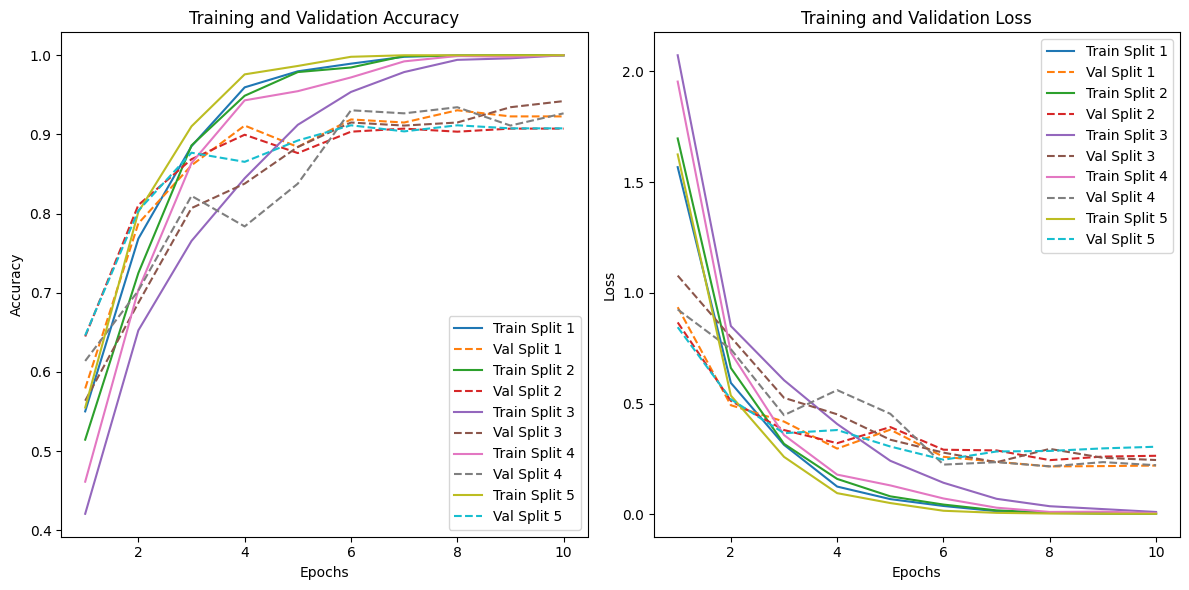

In [15]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = base_model.output

    # Adding Conv2D + ReLU Layers
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding Max Pooling
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Add GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(x)

    # Replacing the last three layers with new fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)  # Add output layer

    model_normalizedd = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model_normalizedd.layers[:15]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model_normalizedd.layers[15:30]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.0001
            lr_mult[layer.name + '/bias:0'] = 0.0001

    # Set learning rate to 10 for the last two dense layers
    for layer in model_normalizedd.layers[30:]:
        lr_mult[layer.name + '/kernel:0'] = 1
        lr_mult[layer.name + '/bias:0'] = 1

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)

    # Compile the model
    model_normalizedd.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model_normalizedd

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model_normalizedd = build_model()

        # Define the ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        width_shift_range=0.1,  # translate horizontally by 10% of total width
        height_shift_range=0.1,  # translate vertically by 10% of total height
        fill_mode='nearest'  # strategy for filling in newly created pixels
    )

    # Generate augmented images batches during training
    train_datagen = datagen.flow(X_train, y_train, batch_size=10)

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/sheepFace_two.keras'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=0)
    history = model_normalizedd.fit(train_datagen, epochs=20, validation_data=(X_test,y_test), verbose=1, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model_normalizedd=load_model(save_path)
    # Evaluate the model
    scores = model_normalizedd.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model_normalizedd.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])
    print("\n")

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


Epoch 1/20
130/130 [==============================] - 24s 146ms/step - loss: 1.7989 - accuracy: 0.3220 - val_loss: 1.2810 - val_accuracy: 0.3827
Epoch 2/20
130/130 [==============================] - 16s 120ms/step - loss: 1.2778 - accuracy: 0.4587 - val_loss: 1.0687 - val_accuracy: 0.5093
Epoch 3/20
130/130 [==============================] - 15s 118ms/step - loss: 1.0691 - accuracy: 0.5761 - val_loss: 0.7457 - val_accuracy: 0.7377
Epoch 4/20
130/130 [==============================] - 16s 119ms/step - loss: 0.8291 - accuracy: 0.6587 - val_loss: 0.5276 - val_accuracy: 0.8210
Epoch 5/20
130/130 [==============================] - 15s 114ms/step - loss: 0.6811 - accuracy: 0.7421 - val_loss: 0.5913 - val_accuracy: 0.7840
Epoch 6/20
130/130 [==============================] - 15s 118ms/step - loss: 0.5906 - accuracy: 0.7838 - val_loss: 0.3870 - val_accuracy: 0.8642
Epoch 7/20
130/130 [==============================] - 16s 119ms/step - loss: 0.5173 - accuracy: 0.8139 - val_loss: 0.3757 - val_ac

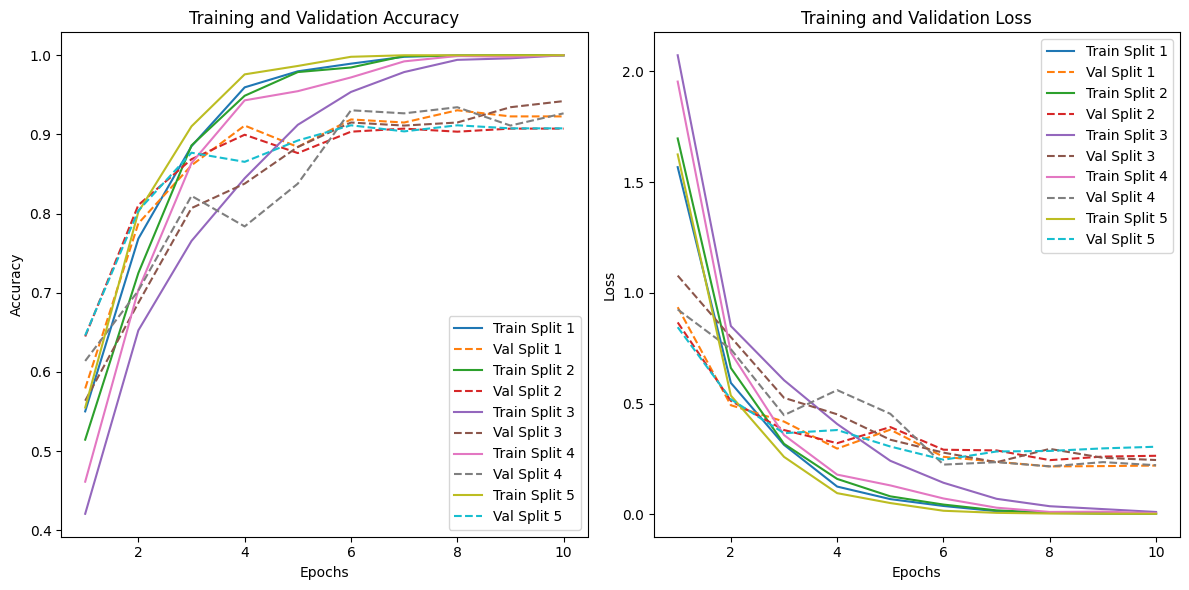

In [16]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze first 10 convolutional layers
    for layer in base_model.layers[:17]:
        layer.trainable = False

    x = base_model.output

    # Flatten to prepare for the fully connected layers
    x = Flatten()(x)

    # Fully connected + ReLU
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)

    # Adding output layer
    predictions = Dense(len(sheep_breed_list), activation='softmax')(x)

    # Create the final model
    model_VGG19 = Model(inputs=base_model.input, outputs=predictions)

    # Custom learning rates
    lr_mult = {}

    # Set learning rate to 0 for the first 10 layers
    for layer in model_VGG19 .layers[:17]:
        lr_mult[layer.name + '/kernel:0'] = 0.0
        lr_mult[layer.name + '/bias:0'] = 0.0

    # Set learning rate to 0.0001 for the next Conv2D layers and the following layers
    for layer in model_VGG19 .layers[17:23]:
        if isinstance(layer, Conv2D):
            lr_mult[layer.name + '/kernel:0'] = 0.001
            lr_mult[layer.name + '/bias:0'] = 0.001

    # Set learning rate to 10 for the last two dense layers
    for layer in model_VGG19 .layers[23:]:
        lr_mult[layer.name + '/kernel:0'] = 0.001
        lr_mult[layer.name + '/bias:0'] = 0.001

    # Use SGD optimizer with initial learning rate of 1e-4
    optimizer = SGD(learning_rate=1e-4,momentum=0.9)

    # Compile the model
    model_VGG19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=[1.] + [10.]*2)

    return model_VGG19

accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# KFold Cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in kf.split(img_data):
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_categorical[train_index], labels_categorical[test_index]

    model_VGG19 = build_model()

    #early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
    save_path='/content/drive/MyDrive/Deep_learning_projects/SheepFull_Data/SheepFace_three.keras'
    checkpoint = ModelCheckpoint(save_path,monitor='val_loss',save_best_only=True,verbose=0)
    history = model_VGG19.fit(X_train, y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.2, callbacks=[checkpoint])

    print("\n")
    print(f'Evaluating the Test metrics')
    model_VGG19=load_model(save_path)
    # Evaluate the model
    scores = model_VGG19.evaluate(X_test, y_test, verbose=1)
    print(f'Test loss for fold {fold_var}: {scores[0]}')
    print(f'Test accuracy for fold {fold_var}: {scores[1]}')

    accuracy_values.append(scores[1])  # Appending accuracy to the list

    # Get predictions from the model
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to categorical labels
    y_pred = np.argmax(model_VGG19.predict(X_test), axis=1)  # Get predictions from the model

    # Calculate and append evaluation metrics for this fold
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print evaluation metrics for this fold
    print(f'Precision for fold {fold_var}: {precision}')
    print(f'Recall for fold {fold_var}: {recall}')
    print(f'F1 Score for fold {fold_var}: {f1}')
    print("\n")

    train_acc_list.append(history.history['accuracy'])
    val_acc_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])

    # Increment the fold number
    fold_var += 1

# Calculate standard deviation of accuracy across folds
accuracy_std_dev = np.std(accuracy_values)
print(f'Standard deviation of accuracy across folds: {accuracy_std_dev}')

# Calculate average of accuracy,precision, recall, and F1 across folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/10
104/104 [==============================] - 22s 154ms/step - loss: 1.6248 - accuracy: 0.5830 - val_loss: 0.6109 - val_accuracy: 0.7683
Epoch 2/10
104/104 [==============================] - 11s 104ms/step - loss: 0.4059 - accuracy: 0.8542 - val_loss: 0.3482 - val_accuracy: 0.8571
Epoch 3/10
104/104 [==============================] - 10s 95ms/step - loss: 0.1213 - accuracy: 0.9614 - val_loss: 0.4795 - val_accuracy: 0.8263
Epoch 4/10
104/104 [==============================] - 11s 106ms/step - loss: 0.0400 - accuracy: 0.9923 - val_loss: 0.2234 - val_accuracy: 0.9266
Epoch 5/10
104/104 [==============================] - 10s 97ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2361 - val_accuracy: 0.9305
Epoch 6/10
104/104 [==============================] - 10s 97ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2241 - val_accuracy: 0.9266
Epoch 7/10
104/104 [==============================] - 11s 107ms/step

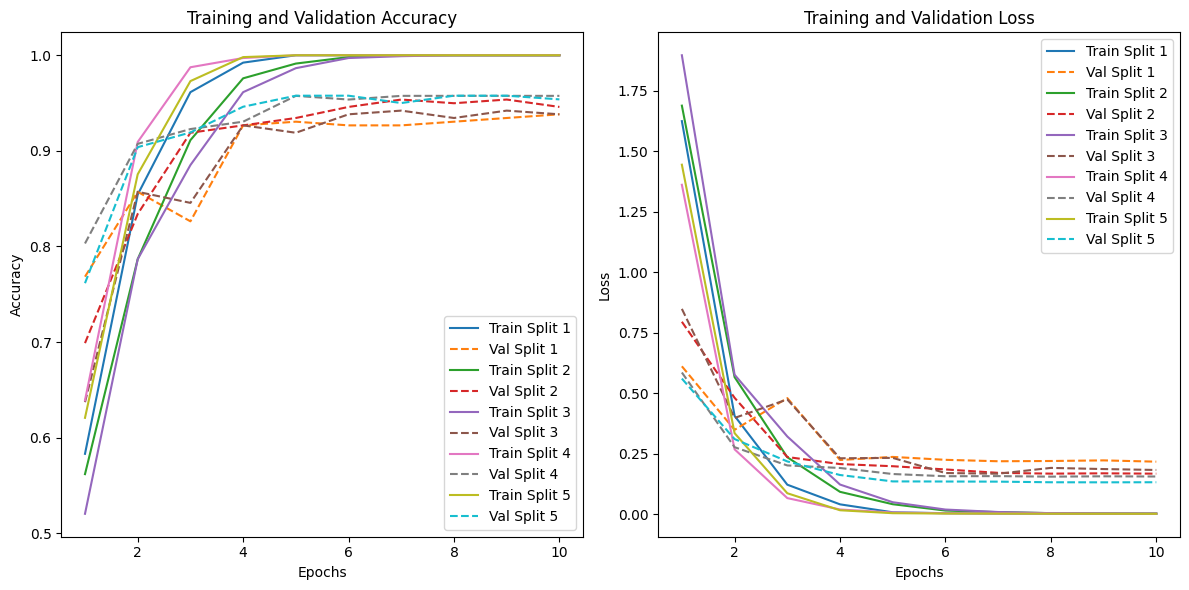

In [9]:
import matplotlib.pyplot as plt

# Determine the maximum length among all lists
max_length = max(len(train_acc) for train_acc in train_acc_list)

# Pad the shorter lists with zeros to match the maximum length
for i in range(n_splits):
    train_acc_list[i] += [0] * (max_length - len(train_acc_list[i]))
    val_acc_list[i] += [0] * (max_length - len(val_acc_list[i]))
    train_loss_list[i] += [0] * (max_length - len(train_loss_list[i]))
    val_loss_list[i] += [0] * (max_length - len(val_loss_list[i]))

# Plotting
epochs = range(1, max_length + 1)

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(epochs, train_acc_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_acc_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(epochs, train_loss_list[i], label=f'Train Split {i+1}')
    plt.plot(epochs, val_loss_list[i], label=f'Val Split {i+1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Load the pre-trained VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Define SVM pipeline
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='linear', probability=True))])

# Initialize lists to store evaluation metrics
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Perform k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
fold_var = 1

for train_index, test_index in skf.split(img_data, labels_encoded):  # Ensure labels_encoded is defined correctly as the non-categorical labels
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]

    # Extract features using the VGG16 model and flatten them
    X_train_features = base_model.predict(preprocess_input(X_train))
    X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)

    X_test_features = base_model.predict(preprocess_input(X_test))
    X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

    # Fit and transform the training data with StandardScaler and train the SVM
    svm_pipeline.fit(X_train_features, y_train)

    # Predict using the trained SVM pipeline
    predictions = svm_pipeline.predict(X_test_features)
    print(f'Fold {fold_var}:')
    print(f'Accuracy: {accuracy_score(y_test, predictions)}')
    print(f'Precision: {precision_score(y_test, predictions, average="weighted")}')
    print(f'Recall: {recall_score(y_test, predictions, average="weighted")}')
    print(f'F1 Score: {f1_score(y_test, predictions, average="weighted")}')

    # Calculate evaluation metrics
    accuracy_values.append(accuracy_score(y_test, predictions))
    precision_values.append(precision_score(y_test, predictions, average='weighted'))
    recall_values.append(recall_score(y_test, predictions, average='weighted'))
    f1_values.append(f1_score(y_test, predictions, average='weighted'))

    # Increment the fold number
    fold_var += 1

# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1 = np.mean(f1_values)

print(f'Average test Accuracy across folds: {avg_accuracy}')
print(f'Average Precision across folds: {avg_precision}')
print(f'Average Recall across folds: {avg_recall}')
print(f'Average F1 Score across folds: {avg_f1}')


11/11 [==============================] - 2s 148ms/step
Fold 1:
Accuracy: 0.9598765432098766
Precision: 0.9620569043250449
Recall: 0.9598765432098766
F1 Score: 0.9595809528875071
11/11 [==============================] - 1s 141ms/step
Fold 2:
Accuracy: 0.9290123456790124
Precision: 0.9307860902476693
Recall: 0.9290123456790124
F1 Score: 0.9292381459241569
11/11 [==============================] - 1s 143ms/step
Fold 3:
Accuracy: 0.9660493827160493
Precision: 0.9663775683757447
Recall: 0.9660493827160493
F1 Score: 0.9658663233744746
11/11 [==============================] - 1s 142ms/step
Fold 4:
Accuracy: 0.9598765432098766
Precision: 0.9613916475549054
Recall: 0.9598765432098766
F1 Score: 0.9598198652756754
11/11 [==============================] - 1s 144ms/step
Fold 5:
Accuracy: 0.9597523219814241
Precision: 0.9601101715746051
Recall: 0.9597523219814241
F1 Score: 0.9598046349590906
Average test Accuracy across folds: 0.9549134273592479
Average Precision across folds: 0.956144476415594
Avera

In [7]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab_Notebooks/Sheep_Full_Images_Classification.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Sheep_Full_Images_Classification.ipynb to pdf
[NbConvertApp] Support files will be in Sheep_Full_Images_Classification_files/
[NbConvertApp] Making directory ./Sheep_Full_Images_Classification_files
[NbConvertApp] Making directory ./Sheep_Full_Images_Classification_files
[NbConvertApp] Making directory ./Sheep_Full_Images_Classification_files
[NbConvertApp] Writing 151921 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 529541 bytes to /content/drive/MyDrive/Colab_Notebooks/Sheep_Full_Images_Classification.pdf
